# 🎵 Analisi Temporale delle Caratteristiche Audio con Librosa 🎵

Questo notebook si concentra sull'estrazione e visualizzazione delle caratteristiche audio nel tempo, mostrando come le proprietà sonore evolvono durante l'esecuzione di un brano musicale. Analizzeremo come le caratteristiche audio si correlano con le emozioni (arousal e valence) in modo dinamico.

## 1. Preparazione dell'ambiente

Importiamo le librerie necessarie per l'analisi audio e la visualizzazione dei dati.

In [2]:
import librosa  # Libreria principale per l'analisi audio
import librosa.display  # Per visualizzare i grafici audio
import matplotlib.pyplot as plt  # Per creare grafici
import numpy as np  # Per calcoli matematici
import pandas as pd  # Per gestire i dati in formato tabellare
import seaborn as sns  # Per grafici statistici più avanzati
from scipy import stats  # Per calcoli statistici

# Impostiamo matplotlib per mostrare grafici più belli
# %matplotlib inline
# plt.style.use('seaborn')  # Utilizziamo uno stile compatibile con le versioni recenti

# Impostiamo alcune opzioni di visualizzazione
plt.rcParams['figure.figsize'] = (14, 6)  # Dimensione predefinita dei grafici
plt.rcParams['font.size'] = 12  # Dimensione del testo nei grafici

## 2. Caricamento di un file audio e delle annotazioni emozionali

Carichiamo un file audio dal dataset DEAM (Database for Emotional Analysis in Music) e le relative annotazioni dinamiche di arousal e valence.

In [5]:
# Percorso del file audio
file_path = r'C:\Users\PC\Desktop\develhope\projects\DEAM_project\DEAM_project\DEAM_audio\MEMD_audio\5.mp3'  # Utilizziamo un file esistente nella cartella MEMD_audio

# Carichiamo il file audio
# y contiene i dati audio (come un'onda sonora)
# sr è la frequenza di campionamento (quanti punti al secondo)
y, sr = librosa.load(file_path, duration=60)  # Limitiamo a 60 secondi per semplicità

print(f"Durata audio: {len(y)/sr:.2f} secondi")
print(f"Frequenza di campionamento: {sr} Hz")

# Simuliamo le annotazioni dinamiche di arousal e valence
# In un caso reale, queste verrebbero caricate da file
# Nota: nel dataset DEAM, le annotazioni sono tipicamente campionate a 2Hz (ogni 500ms)

# Creiamo un array di tempo per le annotazioni (un punto ogni 500ms)
annotation_time = np.arange(0, len(y)/sr, 0.5)

# Simuliamo valori di arousal (eccitazione) che aumentano e diminuiscono nel tempo
# In un caso reale, questi dati verrebbero caricati dal dataset DEAM
arousal = 0.5 + 0.4 * np.sin(2 * np.pi * annotation_time / 30)

# Simuliamo valori di valence (positività) che variano nel tempo
valence = 0.5 + 0.3 * np.sin(2 * np.pi * annotation_time / 20)

# Creiamo un DataFrame per le annotazioni
annotations = pd.DataFrame({
    'time': annotation_time,
    'arousal': arousal,
    'valence': valence
})

print(f"Numero di annotazioni: {len(annotations)}")
annotations.head()  # Mostriamo le prime righe

Durata audio: 45.03 secondi
Frequenza di campionamento: 22050 Hz
Numero di annotazioni: 91


,time,arousal,valence
0,0.0,0.500000,0.500000
1,0.5,0.541811,0.546930
2,1.0,0.583165,0.592705
3,1.5,0.623607,0.636197
4,2.0,0.662695,0.676336


## 3. Visualizzazione della forma d'onda e delle annotazioni emozionali

Visualizziamo la forma d'onda del brano insieme alle annotazioni di arousal e valence per avere una prima panoramica.

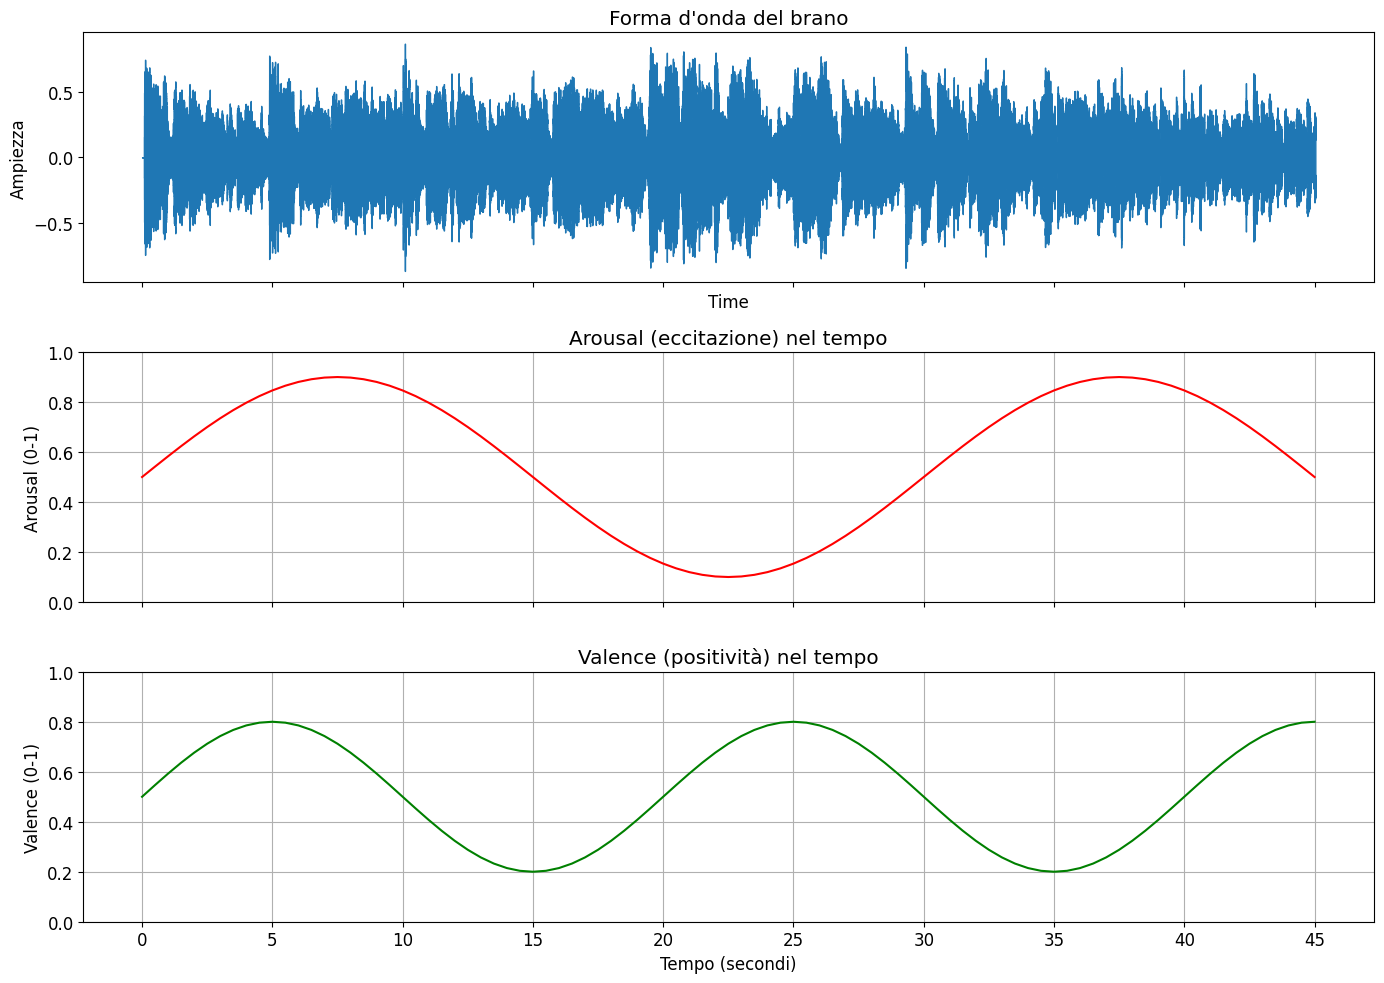

In [6]:
# Creiamo un grafico con 3 sottografici
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Grafico della forma d'onda
librosa.display.waveshow(y, sr=sr, ax=ax1)
ax1.set_title('Forma d\'onda del brano')
ax1.set_ylabel('Ampiezza')

# Grafico dell'arousal nel tempo
ax2.plot(annotations['time'], annotations['arousal'], color='red')
ax2.set_title('Arousal (eccitazione) nel tempo')
ax2.set_ylabel('Arousal (0-1)')
ax2.set_ylim(0, 1)
ax2.grid(True)

# Grafico della valence nel tempo
ax3.plot(annotations['time'], annotations['valence'], color='green')
ax3.set_title('Valence (positività) nel tempo')
ax3.set_xlabel('Tempo (secondi)')
ax3.set_ylabel('Valence (0-1)')
ax3.set_ylim(0, 1)
ax3.grid(True)

plt.tight_layout()
plt.show()

## 4. Estrazione delle caratteristiche audio nel tempo

Ora estraiamo diverse caratteristiche audio e le analizziamo nel tempo, utilizzando finestre temporali.

In [7]:
# Definiamo la dimensione della finestra per l'analisi temporale (in campioni)
# Utilizziamo una finestra di 0.5 secondi per allinearci con le annotazioni
frame_length = int(sr * 0.5)  # 0.5 secondi di audio
hop_length = frame_length  # Non sovrapponiamo le finestre per semplicità

# Calcoliamo il numero di frame che otterremo
n_frames = 1 + int((len(y) - frame_length) / hop_length)
print(f"Numero di frame temporali: {n_frames}")

# Creiamo array vuoti per memorizzare le caratteristiche estratte
frame_times = []  # Tempo centrale di ogni frame
rms_values = []  # Root Mean Square (energia)
spectral_centroid_values = []  # Centroide spettrale (brillantezza)
spectral_contrast_values = []  # Contrasto spettrale (differenza tra picchi e valli)
spectral_rolloff_values = []  # Rolloff spettrale (distribuzione dell'energia)

# Estraiamo le caratteristiche frame per frame
for i in range(n_frames):
    # Calcoliamo l'indice di inizio e fine del frame corrente
    start = i * hop_length
    end = min(start + frame_length, len(y))
    
    # Estraiamo il segmento audio per questo frame
    frame = y[start:end]
    
    # Calcoliamo il tempo centrale di questo frame (in secondi)
    frame_time = (start + (end - start) / 2) / sr
    frame_times.append(frame_time)
    
    # Energia (RMS) - correlata all'intensità/volume
    rms = np.sqrt(np.mean(frame**2))
    rms_values.append(rms)
    
    # Se il frame è troppo corto, alcune funzioni potrebbero fallire
    # Aggiungiamo controlli per evitare errori
    if len(frame) > 0:
        # Centroide spettrale - correlato alla brillantezza/acutezza
        centroid = np.mean(librosa.feature.spectral_centroid(y=frame, sr=sr))
        spectral_centroid_values.append(centroid)
        
        # Contrasto spettrale - correlato alla differenza tra picchi e valli
        contrast = np.mean(librosa.feature.spectral_contrast(y=frame, sr=sr))
        spectral_contrast_values.append(contrast)
        
        # Rolloff spettrale - correlato alla distribuzione dell'energia
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=frame, sr=sr))
        spectral_rolloff_values.append(rolloff)
    else:
        # Se il frame è vuoto, aggiungiamo valori nulli
        spectral_centroid_values.append(0)
        spectral_contrast_values.append(0)
        spectral_rolloff_values.append(0)

# Creiamo un DataFrame con tutte le caratteristiche estratte
features_df = pd.DataFrame({
    'time': frame_times,
    'rms': rms_values,
    'spectral_centroid': spectral_centroid_values,
    'spectral_contrast': spectral_contrast_values,
    'spectral_rolloff': spectral_rolloff_values
})

# Normalizziamo le caratteristiche per facilitare il confronto
features_df['rms_norm'] = features_df['rms'] / features_df['rms'].max()
features_df['centroid_norm'] = features_df['spectral_centroid'] / features_df['spectral_centroid'].max()
features_df['contrast_norm'] = (features_df['spectral_contrast'] - features_df['spectral_contrast'].min()) / (features_df['spectral_contrast'].max() - features_df['spectral_contrast'].min())
features_df['rolloff_norm'] = features_df['spectral_rolloff'] / features_df['spectral_rolloff'].max()

# Mostriamo le prime righe del DataFrame
features_df.head()

Numero di frame temporali: 90


,time,rms,spectral_centroid,spectral_contrast,spectral_rolloff,rms_norm,centroid_norm,contrast_norm,rolloff_norm
0,0.25,0.182169,1979.570212,23.476984,3712.519975,0.790614,0.659112,0.144083,0.635556
1,0.75,0.188051,1959.823862,24.006074,3908.765758,0.816142,0.652537,0.280125,0.669152
2,1.25,0.145910,2206.758522,23.289915,4455.415483,0.633250,0.734756,0.095983,0.762735
3,1.75,0.149216,1746.137210,24.026170,3489.357688,0.647602,0.581388,0.285292,0.597353
4,2.25,0.129655,1585.541940,23.631731,3153.635476,0.562702,0.527917,0.183873,0.539879


## 5. Interpolazione delle annotazioni emozionali

Per confrontare le caratteristiche audio con le annotazioni emozionali, dobbiamo assicurarci che abbiano la stessa frequenza di campionamento. Interpoleremmo le annotazioni per allinearle con i frame audio.

In [8]:
# Interpoliamo le annotazioni per allinearle con i frame audio
from scipy.interpolate import interp1d

# Funzione di interpolazione per arousal
arousal_interp = interp1d(annotations['time'], annotations['arousal'], kind='linear', bounds_error=False, fill_value='extrapolate')

# Funzione di interpolazione per valence
valence_interp = interp1d(annotations['time'], annotations['valence'], kind='linear', bounds_error=False, fill_value='extrapolate')

# Applichiamo l'interpolazione ai tempi dei frame
features_df['arousal'] = arousal_interp(features_df['time'])
features_df['valence'] = valence_interp(features_df['time'])

# Applichiamo un filtro di smoothing per ridurre il rumore nelle caratteristiche
from scipy.ndimage import gaussian_filter1d

# Smoothing delle caratteristiche (sigma controlla il livello di smoothing)
features_df['rms_smooth'] = gaussian_filter1d(features_df['rms_norm'], sigma=2)
features_df['centroid_smooth'] = gaussian_filter1d(features_df['centroid_norm'], sigma=2)
features_df['contrast_smooth'] = gaussian_filter1d(features_df['contrast_norm'], sigma=2)
features_df['rolloff_smooth'] = gaussian_filter1d(features_df['rolloff_norm'], sigma=2)

# Smoothing delle annotazioni
features_df['arousal_smooth'] = gaussian_filter1d(features_df['arousal'], sigma=2)
features_df['valence_smooth'] = gaussian_filter1d(features_df['valence'], sigma=2)

# Mostriamo le prime righe del DataFrame con le nuove colonne
features_df[['time', 'rms_smooth', 'centroid_smooth', 'arousal_smooth', 'valence_smooth']].head()

,time,rms_smooth,centroid_smooth,arousal_smooth,valence_smooth
0,0.25,0.744260,0.658490,0.568453,0.575424
1,0.75,0.721966,0.650802,0.583403,0.591190
2,1.25,0.683829,0.633866,0.609859,0.618649
3,1.75,0.639489,0.607135,0.642878,0.651905
4,2.25,0.597989,0.572419,0.678167,0.685726


## 6. Visualizzazione delle caratteristiche audio nel tempo

Visualizziamo come le caratteristiche audio variano nel tempo e come si correlano con le annotazioni emozionali.

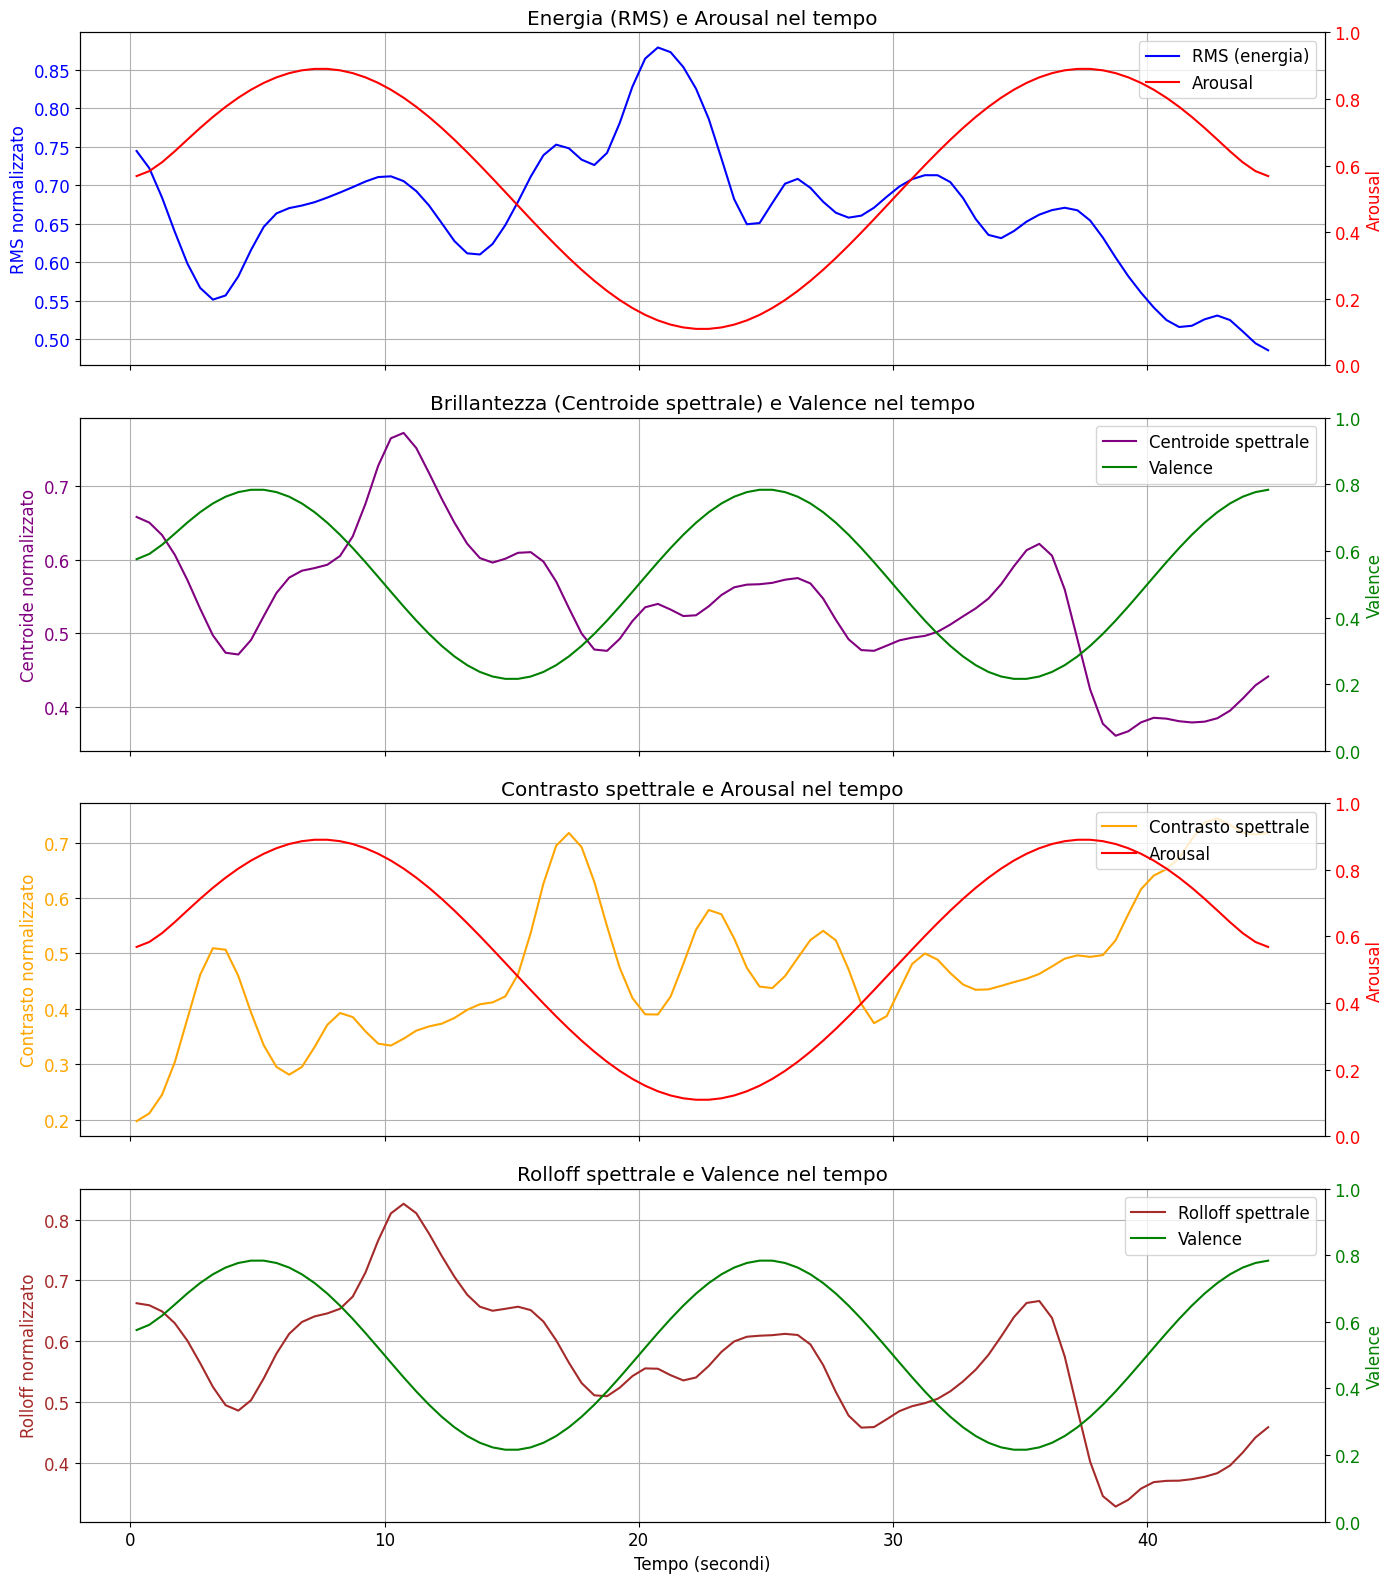

In [9]:
# Creiamo un grafico con 4 sottografici
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# 1. RMS (energia/volume) e Arousal
ax1.plot(features_df['time'], features_df['rms_smooth'], color='blue', label='RMS (energia)')
ax1.set_title('Energia (RMS) e Arousal nel tempo')
ax1.set_ylabel('RMS normalizzato', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Aggiungiamo Arousal sullo stesso grafico (asse y secondario)
ax1_twin = ax1.twinx()
ax1_twin.plot(features_df['time'], features_df['arousal_smooth'], color='red', label='Arousal')
ax1_twin.set_ylabel('Arousal', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.set_ylim(0, 1)

# Aggiungiamo una legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 2. Centroide spettrale (brillantezza) e Valence
ax2.plot(features_df['time'], features_df['centroid_smooth'], color='purple', label='Centroide spettrale')
ax2.set_title('Brillantezza (Centroide spettrale) e Valence nel tempo')
ax2.set_ylabel('Centroide normalizzato', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.grid(True)

# Aggiungiamo Valence sullo stesso grafico (asse y secondario)
ax2_twin = ax2.twinx()
ax2_twin.plot(features_df['time'], features_df['valence_smooth'], color='green', label='Valence')
ax2_twin.set_ylabel('Valence', color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')
ax2_twin.set_ylim(0, 1)

# Aggiungiamo una legenda
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 3. Contrasto spettrale e Arousal
ax3.plot(features_df['time'], features_df['contrast_smooth'], color='orange', label='Contrasto spettrale')
ax3.set_title('Contrasto spettrale e Arousal nel tempo')
ax3.set_ylabel('Contrasto normalizzato', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')
ax3.grid(True)

# Aggiungiamo Arousal sullo stesso grafico (asse y secondario)
ax3_twin = ax3.twinx()
ax3_twin.plot(features_df['time'], features_df['arousal_smooth'], color='red', label='Arousal')
ax3_twin.set_ylabel('Arousal', color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3_twin.set_ylim(0, 1)

# Aggiungiamo una legenda
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 4. Rolloff spettrale e Valence
ax4.plot(features_df['time'], features_df['rolloff_smooth'], color='brown', label='Rolloff spettrale')
ax4.set_title('Rolloff spettrale e Valence nel tempo')
ax4.set_xlabel('Tempo (secondi)')
ax4.set_ylabel('Rolloff normalizzato', color='brown')
ax4.tick_params(axis='y', labelcolor='brown')
ax4.grid(True)

# Aggiungiamo Valence sullo stesso grafico (asse y secondario)
ax4_twin = ax4.twinx()
ax4_twin.plot(features_df['time'], features_df['valence_smooth'], color='green', label='Valence')
ax4_twin.set_ylabel('Valence', color='green')
ax4_twin.tick_params(axis='y', labelcolor='green')
ax4_twin.set_ylim(0, 1)

# Aggiungiamo una legenda
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

## 7. Analisi della correlazione tra caratteristiche audio ed emozioni

Calcoliamo e visualizziamo la correlazione tra le caratteristiche audio estratte e le annotazioni emozionali.

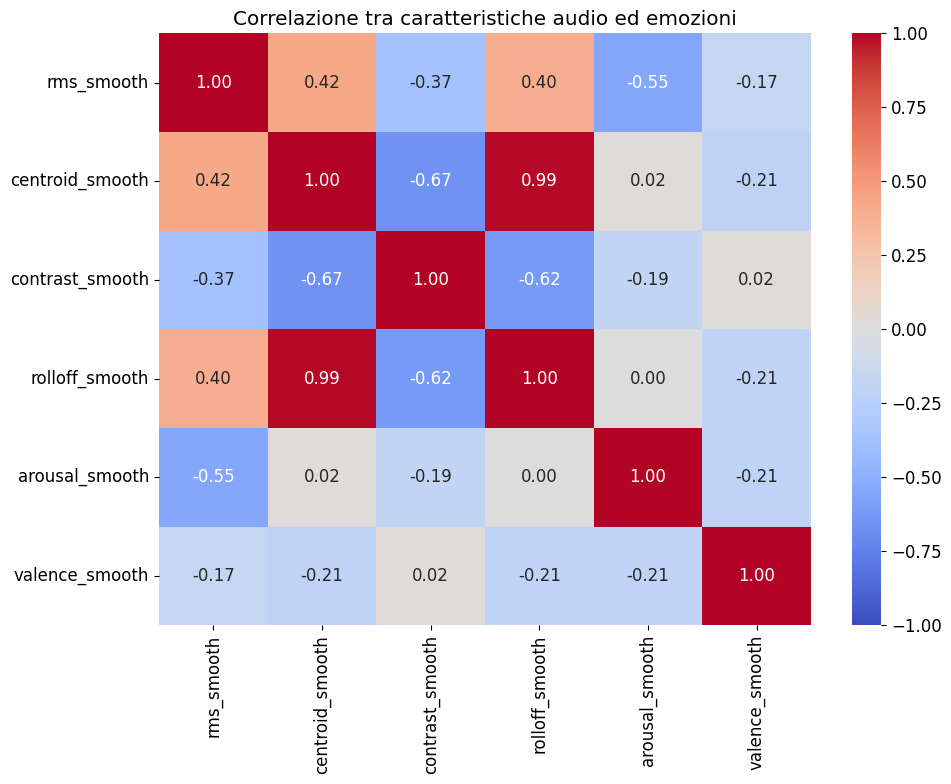

<Figure size 1200x600 with 0 Axes>

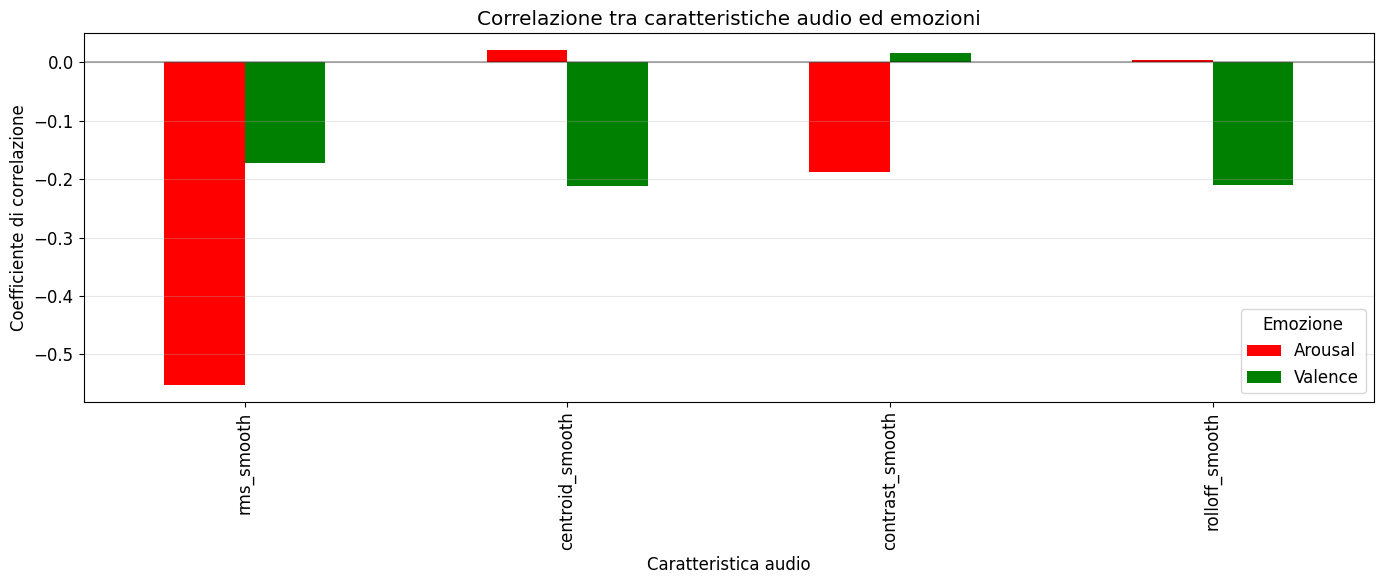

In [10]:
# Calcoliamo la matrice di correlazione
correlation_columns = ['rms_smooth', 'centroid_smooth', 'contrast_smooth', 'rolloff_smooth', 'arousal_smooth', 'valence_smooth']
correlation_matrix = features_df[correlation_columns].corr()

# Visualizziamo la matrice di correlazione come heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlazione tra caratteristiche audio ed emozioni')
plt.tight_layout()
plt.show()

# Estraiamo e visualizziamo le correlazioni specifiche con arousal e valence
arousal_correlations = correlation_matrix['arousal_smooth'].drop(['arousal_smooth', 'valence_smooth'])
valence_correlations = correlation_matrix['valence_smooth'].drop(['arousal_smooth', 'valence_smooth'])

# Creiamo un DataFrame per facilitare la visualizzazione
emotion_correlations = pd.DataFrame({
    'Arousal': arousal_correlations,
    'Valence': valence_correlations
})

# Visualizziamo le correlazioni come grafico a barre
plt.figure(figsize=(12, 6))
emotion_correlations.plot(kind='bar', color=['red', 'green'])
plt.title('Correlazione tra caratteristiche audio ed emozioni')
plt.xlabel('Caratteristica audio')
plt.ylabel('Coefficiente di correlazione')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Emozione')
plt.tight_layout()
plt.show()

## 8. Conclusioni

In questo notebook, abbiamo esplorato come le caratteristiche audio estratte con Librosa si correlano con le emozioni (arousal e valence) nel tempo. Abbiamo visto come:

1. L'energia (RMS) tende a correlarsi con l'arousal, indicando che brani più energici sono percepiti come più eccitanti
2. Il centroide spettrale (brillantezza) può correlarsi con la valence, suggerendo che suoni più brillanti possono essere percepiti come più positivi
3. Il contrasto spettrale e il rolloff spettrale mostrano correlazioni variabili con le emozioni

Queste analisi dimostrano come l'analisi temporale delle caratteristiche audio possa fornire informazioni preziose sulla percezione emotiva della musica.